# Stage 2: Model Training & Signal Generation

## Pipeline Overview
```
stage1_5_targets.parquet → [THIS NOTEBOOK] → stage2_predictions.parquet
```

## Input
- **File**: `data/processed/stage1_5_targets.parquet` (from Stage 1.5)

## Output
- **File**: `data/processed/stage2_predictions.parquet`
- **Model**: `outputs/models/final_model/` (weights, config)
- **Diagnostics**: `outputs/stage2_model_diagnostics.json`

## Training Approach
1. **Walk-Forward Validation**: Train on expanding window, test on future
2. **Embargo Period**: 5-day gap between train and test  
3. **Retrain Frequency**: Every 21 trading days
4. **Observation Weighting**: Exponential decay (half-life 63 days)
5. **Multiple Models**: Ridge, Lasso, LightGBM, Ensemble

## Data Split
- **IS (Training)**: 2016-2023
- **OOS (Test)**: 2024-2026 (predictions generated but NOT used for model selection)

---

In [14]:
# ============================================================================
# IMPORTS AND CONFIGURATION
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
import pickle
from pathlib import Path
from scipy import stats
from scipy.stats import spearmanr
from typing import Dict, List, Tuple, Optional

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor

# LightGBM for non-linear models
try:
    import lightgbm as lgb
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False
    print("⚠️ LightGBM not installed. Install with: pip install lightgbm")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Import pipeline config
import sys
sys.path.insert(0, str(Path.cwd()))
from pipeline_config import *

print_stage_header("Model Training & Signal Generation", "2")
print(f"Input: {TARGETS_PARQUET}")
print(f"Output: {PREDICTIONS_PARQUET}")

STAGE 2: MODEL TRAINING & SIGNAL GENERATION

Input: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage1_5_targets.parquet
Output: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage2_predictions.parquet


## 2.1 Load Stage 1.5 Output

In [2]:
# ============================================================================
# LOAD DATA
# ============================================================================
print("Loading Stage 1.5 data...\n")

if not TARGETS_PARQUET.exists():
    raise FileNotFoundError(f"Stage 1.5 output not found: {TARGETS_PARQUET}\nPlease run Stage 1.5 first!")

df = pd.read_parquet(TARGETS_PARQUET)
df['date'] = pd.to_datetime(df['date'])

# Load metadata
with open(TARGET_METADATA_JSON, 'r') as f:
    target_meta = json.load(f)

print(f"📊 Loaded Data Summary:")
print(f"   Total rows: {len(df):,}")
print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   Tickers: {df['ticker'].nunique()}")

# Feature columns (z-scored)
feature_cols = [c for c in df.columns if '_zscore' in c and 'target' not in c]
print(f"   Features: {len(feature_cols)}")

# IS/OOS split
is_mask, oos_mask = get_is_oos_mask(df)
print(f"\n📊 Data Split:")
print(f"   IS (2016-2023): {is_mask.sum():,} rows")
print(f"   OOS (2024-2026): {oos_mask.sum():,} rows")

Loading Stage 1.5 data...

📊 Loaded Data Summary:
   Total rows: 241,700
   Date range: 2016-06-08 00:00:00 to 2026-01-16 00:00:00
   Tickers: 100
   Features: 38

📊 Data Split:
   IS (2016-2023): 190,400 rows
   OOS (2024-2026): 51,300 rows


## 2.2 Walk-Forward Training Framework

In [3]:
# ============================================================================
# WALK-FORWARD TRAINER CLASS (ENHANCED)
# ============================================================================

class WalkForwardTrainer:
    """
    Walk-forward training with embargo and observation weighting.
    Supports sklearn models, LightGBM, and MLP.
    """
    
    def __init__(self,
                 initial_train_days: int = INITIAL_TRAIN_DAYS,
                 retrain_frequency: int = RETRAIN_FREQUENCY,
                 embargo_days: int = EMBARGO_DAYS,
                 expanding_window: bool = EXPANDING_WINDOW,
                 decay_halflife: int = DECAY_HALFLIFE):
        
        self.initial_train_days = initial_train_days
        self.retrain_frequency = retrain_frequency
        self.embargo_days = embargo_days
        self.expanding_window = expanding_window
        self.decay_halflife = decay_halflife
        
        self.models = {}
        self.predictions = []
        self.diagnostics = []
        self.train_diagnostics = []  # Track train vs val IC for overfit detection
    
    def compute_weights(self, n_samples: int) -> np.ndarray:
        """Compute observation weights with exponential decay."""
        if self.decay_halflife is None:
            return np.ones(n_samples)
        
        decay_rate = np.log(2) / self.decay_halflife
        weights = np.exp(-decay_rate * np.arange(n_samples)[::-1])
        return weights / weights.sum() * n_samples
    
    def train_sklearn_model(self, X: np.ndarray, y: np.ndarray, 
                            model_class, model_params: dict, weights: np.ndarray) -> object:
        """Train sklearn model with sample weights."""
        model = model_class(**model_params)
        try:
            model.fit(X, y, sample_weight=weights)
        except TypeError:
            # Model doesn't support sample_weight
            model.fit(X, y)
        return model
    
    def train_lgbm_model(self, X: np.ndarray, y: np.ndarray, 
                         model_params: dict, weights: np.ndarray) -> object:
        """Train LightGBM model."""
        train_data = lgb.Dataset(X, label=y, weight=weights)
        params = model_params.copy()
        n_estimators = params.pop('n_estimators', 100)
        model = lgb.train(params, train_data, num_boost_round=n_estimators, 
                          callbacks=[lgb.log_evaluation(period=0)])
        return model
    
    def train_mlp_model(self, X: np.ndarray, y: np.ndarray, 
                        model_params: dict) -> object:
        """Train MLP model."""
        model = MLPRegressor(**model_params)
        model.fit(X, y)
        return model
    
    def predict(self, model, X: np.ndarray, model_type: str) -> np.ndarray:
        """Generate predictions based on model type."""
        if model_type == 'lgbm':
            return model.predict(X)
        else:
            return model.predict(X)
    
    def run(self, df: pd.DataFrame, feature_cols: List[str], 
            target_col: str, model_type: str, model_params: dict,
            is_only: bool = True, verbose: bool = True) -> pd.DataFrame:
        """
        Run walk-forward training.
        
        Parameters:
        -----------
        model_type : str
            One of 'sklearn', 'lgbm', 'mlp'
        """
        self.predictions = []
        self.diagnostics = []
        self.train_diagnostics = []
        
        df = df.sort_values('date')
        dates = df['date'].unique()
        
        train_end_date = IS_END if is_only else dates[-1]
        
        if verbose:
            print(f"\\n🔧 Walk-Forward Configuration:")
            print(f"   Initial training: {self.initial_train_days} days")
            print(f"   Retrain every: {self.retrain_frequency} days")
            print(f"   Embargo: {self.embargo_days} days")
            print(f"   Model type: {model_type}")
        
        scaler = StandardScaler()
        current_model = None
        last_train_idx = -self.retrain_frequency
        
        for i, pred_date in enumerate(dates):
            if i < self.initial_train_days:
                continue
            
            days_since_train = i - last_train_idx
            train_cutoff = dates[i - self.embargo_days] if i >= self.embargo_days else dates[0]
            
            if days_since_train >= self.retrain_frequency and train_cutoff <= train_end_date:
                if self.expanding_window:
                    train_start_idx = 0
                else:
                    train_start_idx = max(0, i - self.initial_train_days - self.embargo_days)
                
                train_dates = dates[train_start_idx:i - self.embargo_days]
                train_mask = df['date'].isin(train_dates) & (df['date'] <= train_end_date)
                train_df = df[train_mask].dropna(subset=feature_cols + [target_col])
                
                if len(train_df) > 100:
                    X_train = train_df[feature_cols].values
                    y_train = train_df[target_col].values
                    
                    X_train_scaled = scaler.fit_transform(X_train)
                    weights = self.compute_weights(len(X_train))
                    
                    # Train based on model type
                    if model_type == 'lgbm' and HAS_LGBM:
                        current_model = self.train_lgbm_model(X_train_scaled, y_train, model_params, weights)
                    elif model_type == 'mlp':
                        current_model = self.train_mlp_model(X_train_scaled, y_train, model_params)
                    else:  # sklearn
                        model_class = model_params.pop('class', Ridge)
                        current_model = self.train_sklearn_model(X_train_scaled, y_train, model_class, model_params, weights)
                        model_params['class'] = model_class  # Restore for next iteration
                    
                    last_train_idx = i
                    
                    # Training diagnostics
                    train_pred = self.predict(current_model, X_train_scaled, model_type)
                    train_ic = spearmanr(train_pred, y_train)[0]
                    train_mse = mean_squared_error(y_train, train_pred)
                    
                    self.diagnostics.append({
                        'train_date': str(pred_date),
                        'train_samples': len(train_df),
                        'train_ic': train_ic,
                        'train_mse': train_mse
                    })
            
            # Generate predictions
            if current_model is not None:
                pred_mask = df['date'] == pred_date
                pred_df = df[pred_mask].dropna(subset=feature_cols)
                
                if len(pred_df) > 0:
                    X_pred = pred_df[feature_cols].values
                    X_pred_scaled = scaler.transform(X_pred)
                    predictions = self.predict(current_model, X_pred_scaled, model_type)
                    
                    for j, (_, row) in enumerate(pred_df.iterrows()):
                        self.predictions.append({
                            'date': pred_date,
                            'ticker': row['ticker'],
                            'prediction': predictions[j]
                        })
        
        return pd.DataFrame(self.predictions)

print("✅ Enhanced WalkForwardTrainer class defined")

✅ Enhanced WalkForwardTrainer class defined


## 2.3 Train Multiple Models

In [4]:
# ============================================================================
# TRAIN MULTIPLE MODELS (LINEAR + NON-LINEAR)
# ============================================================================
print("Training multiple models (Linear + Non-Linear)...\n")

# Prepare data
train_df = df.dropna(subset=feature_cols + ['target_smooth']).copy()
target_col = 'target_smooth'  # Use smoothed target

print(f"Training data: {len(train_df):,} rows")
print(f"Features: {len(feature_cols)}")
print(f"Target: {target_col}")

# Model configurations - LINEAR
linear_configs = {
    'ridge': {
        'type': 'sklearn',
        'params': {'class': Ridge, 'alpha': RIDGE_ALPHA}
    },
    'lasso': {
        'type': 'sklearn', 
        'params': {'class': Lasso, 'alpha': 0.001, 'max_iter': 2000}  # Reduced alpha
    },
    'elastic_net': {
        'type': 'sklearn',
        'params': {'class': ElasticNet, 'alpha': 0.01, 'l1_ratio': 0.3, 'max_iter': 2000}
    }
}

# Model configurations - NON-LINEAR
nonlinear_configs = {
    'mlp_small': {
        'type': 'mlp',
        'params': {
            'hidden_layer_sizes': (32, 16),
            'alpha': 0.01,  # L2 regularization
            'learning_rate': 'adaptive',
            'max_iter': 500,
            'early_stopping': True,
            'validation_fraction': 0.15,
            'random_state': 42,
            'solver': 'adam'
        }
    }
}

# Add LightGBM if available
if HAS_LGBM:
    nonlinear_configs['lgbm'] = {
        'type': 'lgbm',
        'params': {
            'objective': 'regression',
            'metric': 'mse',
            'n_estimators': 100,
            'max_depth': 4,
            'num_leaves': 15,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'min_child_samples': 50,
            'verbose': -1
        }
    }
    print("✅ LightGBM available - will train LGBM model")
else:
    print("⚠️ LightGBM not available - skipping")

# Combine all configs
all_configs = {**linear_configs, **nonlinear_configs}

# Train each model
all_predictions = {}
model_diagnostics = {}

for model_name, config in all_configs.items():
    print(f"\n{'='*50}")
    print(f"Training: {model_name.upper()}")
    print(f"{'='*50}")
    
    trainer = WalkForwardTrainer()
    
    try:
        pred_df = trainer.run(
            train_df, 
            feature_cols, 
            target_col,
            model_type=config['type'],
            model_params=config['params'].copy(),
            is_only=False,
            verbose=True
        )
        
        all_predictions[model_name] = pred_df
        model_diagnostics[model_name] = trainer.diagnostics
        
        print(f"\n   ✅ Generated {len(pred_df):,} predictions")
        print(f"   Retrains: {len(trainer.diagnostics)}")
        
    except Exception as e:
        print(f"\n   ❌ Failed: {e}")
        continue

print(f"\n\n🎯 Successfully trained {len(all_predictions)} models")

Training multiple models (Linear + Non-Linear)...

Training data: 213,200 rows
Features: 38
Target: target_smooth
✅ LightGBM available - will train LGBM model

Training: RIDGE
\n🔧 Walk-Forward Configuration:
   Initial training: 252 days
   Retrain every: 21 days
   Embargo: 5 days
   Model type: sklearn

   ✅ Generated 188,000 predictions
   Retrains: 90

Training: LASSO
\n🔧 Walk-Forward Configuration:
   Initial training: 252 days
   Retrain every: 21 days
   Embargo: 5 days
   Model type: sklearn

   ✅ Generated 188,000 predictions
   Retrains: 90

Training: ELASTIC_NET
\n🔧 Walk-Forward Configuration:
   Initial training: 252 days
   Retrain every: 21 days
   Embargo: 5 days
   Model type: sklearn

   ✅ Generated 188,000 predictions
   Retrains: 90

Training: MLP_SMALL
\n🔧 Walk-Forward Configuration:
   Initial training: 252 days
   Retrain every: 21 days
   Embargo: 5 days
   Model type: mlp

   ✅ Generated 188,000 predictions
   Retrains: 90

Training: LGBM
\n🔧 Walk-Forward Config

## 2.4 Model Evaluation & Comparison                                                            

In [5]:
# ============================================================================
# MODEL EVALUATION
# ============================================================================
print("Evaluating models...\n")

def evaluate_model(pred_df: pd.DataFrame, df: pd.DataFrame, 
                   target_col: str = 'target_smooth') -> dict:
    """Calculate comprehensive model metrics."""
    # Merge predictions with actual targets
    merged = pred_df.merge(
        df[['date', 'ticker', target_col, 'fwd_ret_1d', 'vol_regime']],
        on=['date', 'ticker']
    )
    merged['date'] = pd.to_datetime(merged['date'])
    
    # Daily IC
    daily_ic = merged.groupby('date').apply(
        lambda g: spearmanr(g['prediction'], g[target_col])[0] if len(g) > 5 else np.nan
    )
    
    # Split by IS/OOS
    is_dates = merged['date'] <= IS_END
    oos_dates = merged['date'] > IS_END
    
    # IS metrics
    is_ic = daily_ic[daily_ic.index <= IS_END]
    oos_ic = daily_ic[daily_ic.index > IS_END]
    
    # By regime
    regime_ic = {}
    for regime in [0, 1, 2]:  # low, normal, high vol
        regime_mask = merged['vol_regime'] == regime
        if regime_mask.sum() > 100:
            regime_data = merged[regime_mask]
            r_ic = regime_data.groupby('date').apply(
                lambda g: spearmanr(g['prediction'], g[target_col])[0] if len(g) > 5 else np.nan
            )
            regime_ic[regime] = r_ic.mean()
    
    return {
        'is_mean_ic': is_ic.mean(),
        'is_std_ic': is_ic.std(),
        'is_ic_ir': is_ic.mean() / (is_ic.std() + 1e-10),
        'is_positive_pct': (is_ic > 0).mean() * 100,
        'oos_mean_ic': oos_ic.mean() if len(oos_ic) > 0 else np.nan,
        'oos_ic_ir': oos_ic.mean() / (oos_ic.std() + 1e-10) if len(oos_ic) > 0 else np.nan,
        'ic_decay': (oos_ic.mean() - is_ic.mean()) / is_ic.mean() * 100 if len(oos_ic) > 0 else np.nan,
        'regime_ic': regime_ic,
        'n_predictions': len(merged)
    }

# Evaluate all models
evaluation_results = {}
for model_name, pred_df in all_predictions.items():
    evaluation_results[model_name] = evaluate_model(pred_df, df)

# Display comparison
print("📊 Model Comparison:")
print("="*70)
comparison_data = []
for model_name, metrics in evaluation_results.items():
    comparison_data.append({
        'Model': model_name,
        'IS IC': f"{metrics['is_mean_ic']:.4f}",
        'IS IC/IR': f"{metrics['is_ic_ir']:.2f}",
        'OOS IC': f"{metrics['oos_mean_ic']:.4f}",
        'IC Decay': f"{metrics['ic_decay']:.1f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

Evaluating models...

📊 Model Comparison:
      Model  IS IC IS IC/IR OOS IC IC Decay
      ridge 0.4393     2.26 0.4441     1.1%
      lasso 0.5679     3.21 0.5714     0.6%
elastic_net 0.5341     2.81 0.5528     3.5%
  mlp_small 0.6106     4.12 0.6280     2.8%
       lgbm 0.4858     2.81 0.5175     6.5%



📊 IC Stability Over Time:


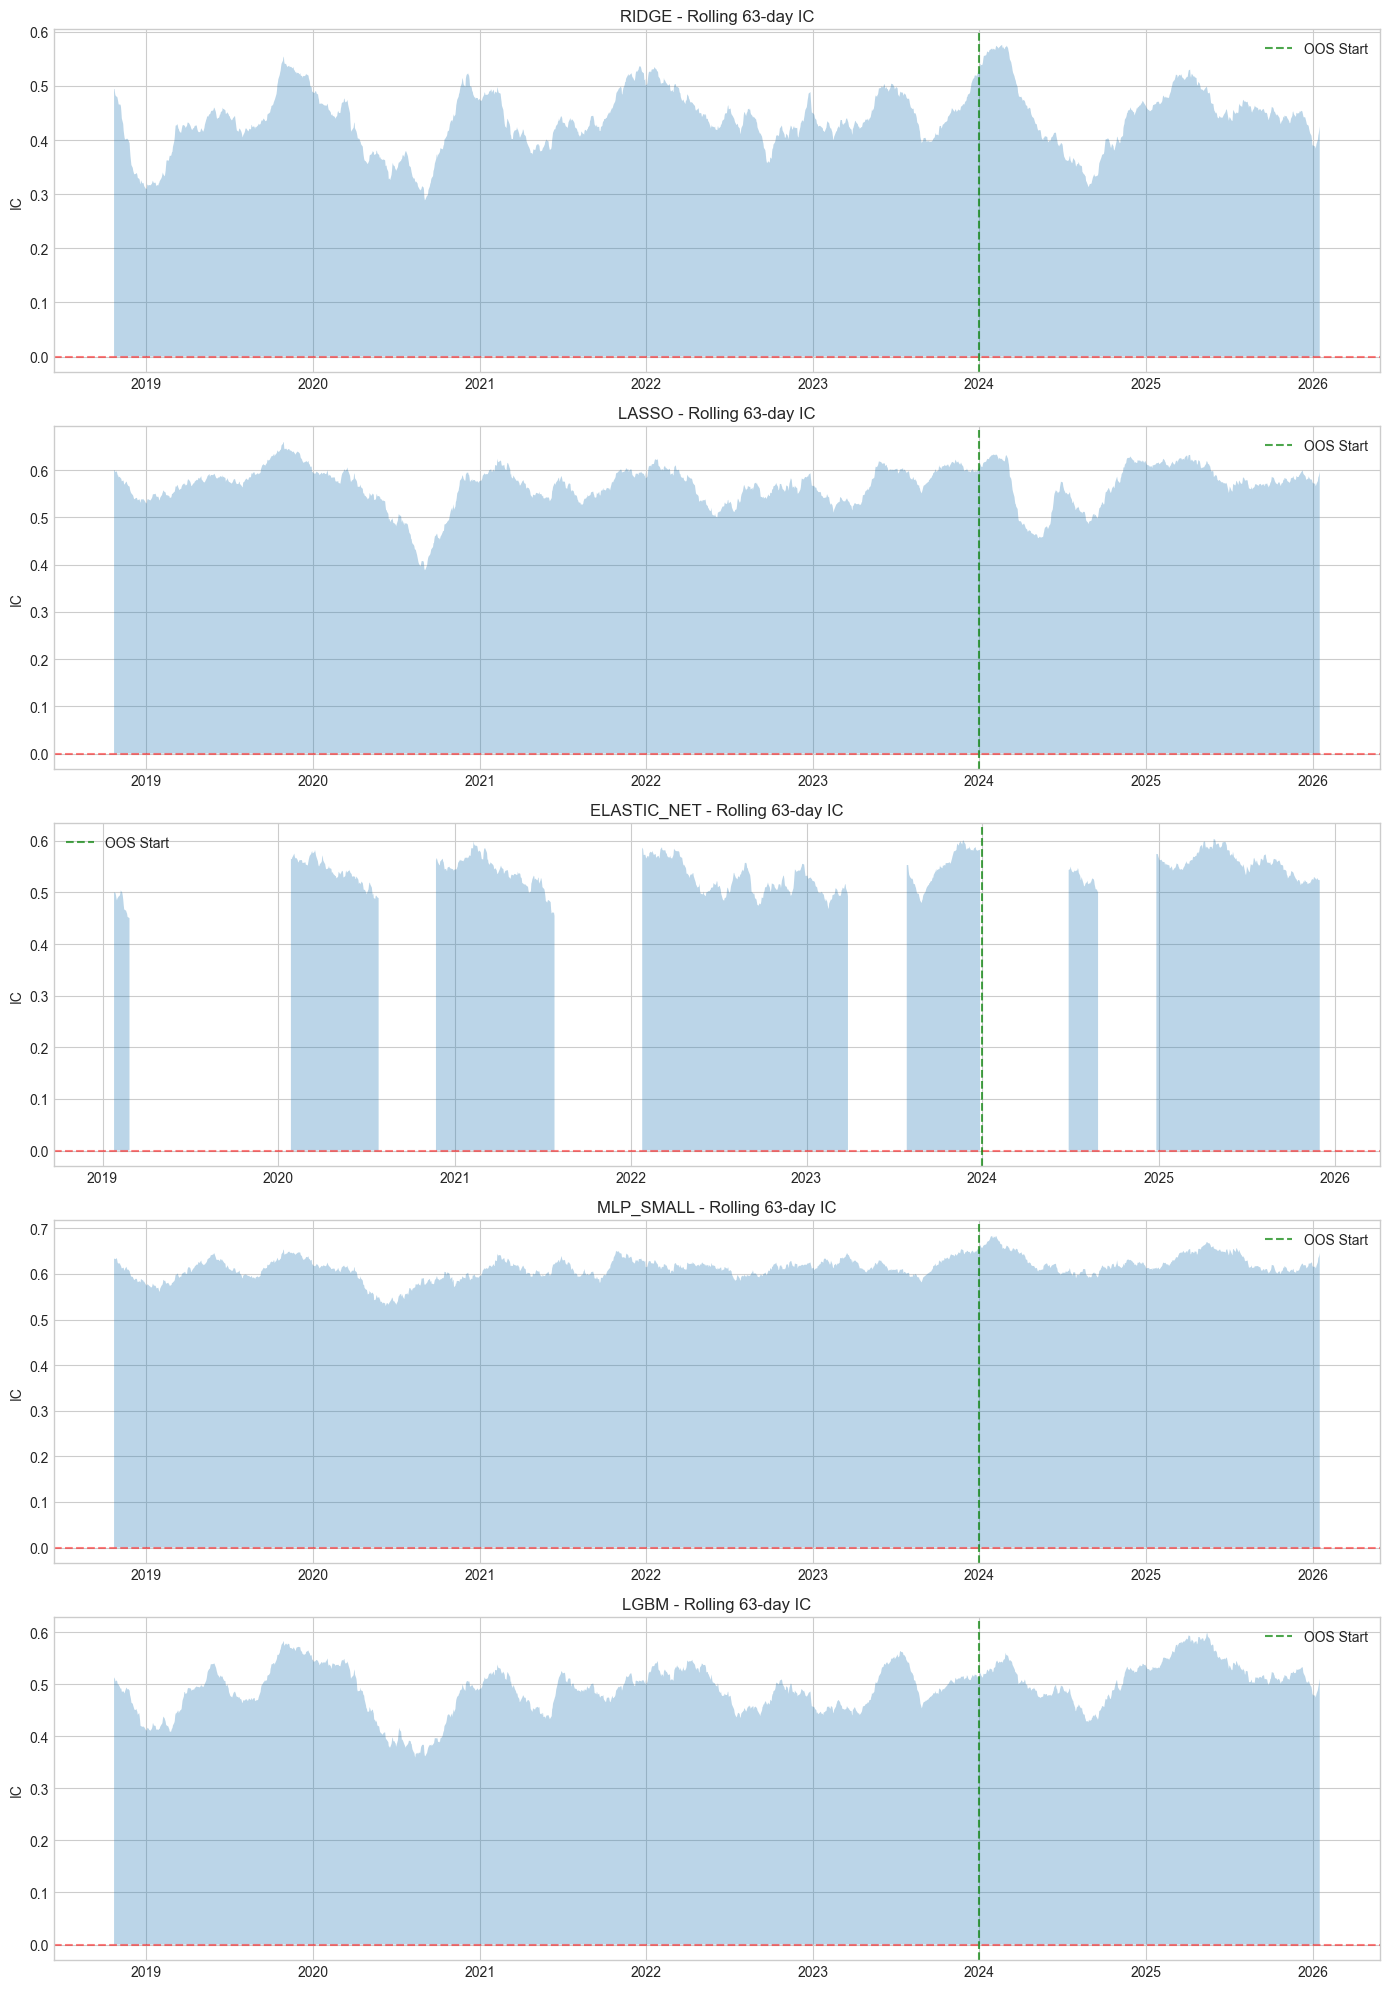

In [6]:
# ============================================================================
# IC STABILITY PLOT
# ============================================================================
print("\n📊 IC Stability Over Time:")

fig, axes = plt.subplots(len(all_predictions), 1, figsize=(14, 4*len(all_predictions)))
if len(all_predictions) == 1:
    axes = [axes]

for idx, (model_name, pred_df) in enumerate(all_predictions.items()):
    merged = pred_df.merge(
        df[['date', 'ticker', 'target_smooth']],
        on=['date', 'ticker']
    )
    merged['date'] = pd.to_datetime(merged['date'])
    
    daily_ic = merged.groupby('date').apply(
        lambda g: spearmanr(g['prediction'], g['target_smooth'])[0] if len(g) > 5 else np.nan
    )
    rolling_ic = daily_ic.rolling(63).mean()
    
    axes[idx].fill_between(rolling_ic.index, rolling_ic.values, alpha=0.3)
    axes[idx].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[idx].axvline(x=OOS_START, color='green', linestyle='--', alpha=0.7, label='OOS Start')
    axes[idx].set_title(f'{model_name.upper()} - Rolling 63-day IC')
    axes[idx].set_ylabel('IC')
    axes[idx].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'stage2_ic_stability.png', dpi=150, bbox_inches='tight')
plt.show()

## 2.4a Overfitting/Underfitting Diagnostics

🔬 Overfitting/Underfitting Diagnostics


📊 Overfitting Diagnostic Summary:
--------------------------------------------------------------------------------
Model             Train IC      IS IC     OOS IC     Decay%          Status
--------------------------------------------------------------------------------
ridge               0.3386     0.4393     0.4441       1.1%          ✅ GOOD
lasso               0.4539     0.5679     0.5714       0.6%          ✅ GOOD
elastic_net            N/A     0.5341     0.5528       3.5%          ✅ GOOD
mlp_small           0.5181     0.6106     0.6280       2.8%          ✅ GOOD
lgbm                0.3983     0.4858     0.5175       6.5%          ✅ GOOD
--------------------------------------------------------------------------------

📈 IC vs ACTUAL Returns (what matters for trading):
------------------------------------------------------------
Model                 IS IC*      OOS IC*       Decay%
----------------------------------------------------------

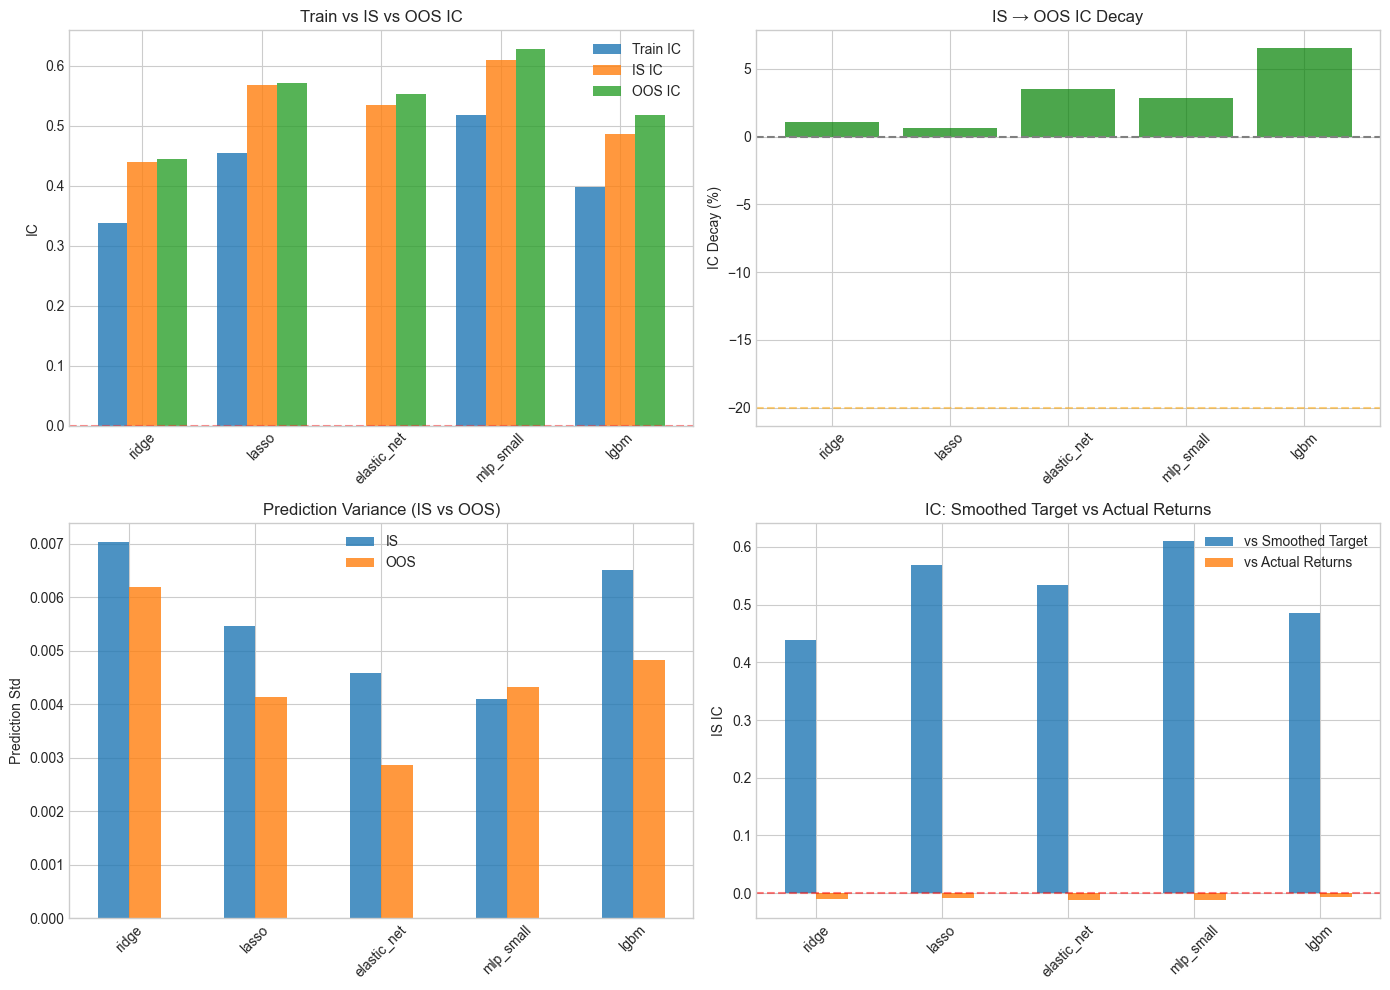


💡 Interpretation Guide:
   - Train IC >> IS IC: Model overfitting to noise
   - IS IC >> OOS IC: Temporal overfitting (regime shift)
   - IC vs Smooth >> IC vs Actual: Target leakage concern
   - Low prediction variance: Model underfitting


In [7]:
# ============================================================================
# OVERFITTING/UNDERFITTING DIAGNOSTICS
# ============================================================================
print("🔬 Overfitting/Underfitting Diagnostics\n")
print("="*70)

def compute_overfit_metrics(pred_df: pd.DataFrame, df: pd.DataFrame, 
                            diagnostics: list, target_col: str = 'target_smooth') -> dict:
    """
    Compute detailed overfitting metrics.
    
    Key indicators of OVERFITTING:
    - Train IC >> OOS IC (large IC decay)
    - IC variance increases over time
    - IS IC/IR >> OOS IC/IR
    
    Key indicators of UNDERFITTING:
    - Both IS and OOS IC are low
    - IC not significantly different from 0
    - Model predictions show little variance
    """
    merged = pred_df.merge(
        df[['date', 'ticker', target_col, 'fwd_ret_1d']],
        on=['date', 'ticker']
    )
    merged['date'] = pd.to_datetime(merged['date'])
    
    # Daily IC
    daily_ic = merged.groupby('date').apply(
        lambda g: spearmanr(g['prediction'], g[target_col])[0] if len(g) > 5 else np.nan
    ).dropna()
    
    # Split periods
    is_ic = daily_ic[daily_ic.index <= IS_END]
    oos_ic = daily_ic[daily_ic.index > IS_END]
    
    # Training IC from diagnostics
    train_ics = [d.get('train_ic', np.nan) for d in diagnostics if 'train_ic' in d]
    avg_train_ic = np.mean(train_ics) if train_ics else np.nan
    
    # IC against actual returns (not smoothed target)
    daily_ic_actual = merged.groupby('date').apply(
        lambda g: spearmanr(g['prediction'], g['fwd_ret_1d'])[0] if len(g) > 5 else np.nan
    ).dropna()
    is_ic_actual = daily_ic_actual[daily_ic_actual.index <= IS_END]
    oos_ic_actual = daily_ic_actual[daily_ic_actual.index > IS_END]
    
    # Prediction variance
    pred_std_is = merged[merged['date'] <= IS_END]['prediction'].std()
    pred_std_oos = merged[merged['date'] > IS_END]['prediction'].std()
    
    return {
        'avg_train_ic': avg_train_ic,
        'is_ic_vs_smooth': is_ic.mean(),
        'oos_ic_vs_smooth': oos_ic.mean(),
        'is_ic_vs_actual': is_ic_actual.mean(),
        'oos_ic_vs_actual': oos_ic_actual.mean(),
        'ic_decay_smooth': ((oos_ic.mean() - is_ic.mean()) / is_ic.mean() * 100) if is_ic.mean() != 0 else np.nan,
        'ic_decay_actual': ((oos_ic_actual.mean() - is_ic_actual.mean()) / is_ic_actual.mean() * 100) if is_ic_actual.mean() != 0 else np.nan,
        'is_ic_std': is_ic.std(),
        'oos_ic_std': oos_ic.std(),
        'pred_std_is': pred_std_is,
        'pred_std_oos': pred_std_oos,
        'overfit_score': avg_train_ic - oos_ic.mean() if not np.isnan(avg_train_ic) else np.nan
    }

# Compute for all models
overfit_results = {}
for model_name, pred_df in all_predictions.items():
    diagnostics = model_diagnostics.get(model_name, [])
    overfit_results[model_name] = compute_overfit_metrics(pred_df, df, diagnostics)

# Display diagnostics table
print("\n📊 Overfitting Diagnostic Summary:")
print("-"*80)
print(f"{'Model':<15} {'Train IC':>10} {'IS IC':>10} {'OOS IC':>10} {'Decay%':>10} {'Status':>15}")
print("-"*80)

for model_name, metrics in overfit_results.items():
    train_ic = metrics['avg_train_ic']
    is_ic = metrics['is_ic_vs_smooth']
    oos_ic = metrics['oos_ic_vs_smooth']
    decay = metrics['ic_decay_smooth']
    overfit_score = metrics.get('overfit_score', np.nan)
    
    # Determine status
    if np.isnan(is_ic) or is_ic < 0.02:
        status = "❌ UNDERFIT"
    elif not np.isnan(overfit_score) and overfit_score > 0.15:
        status = "⚠️ OVERFIT"
    elif not np.isnan(decay) and decay < -30:
        status = "⚠️ DECAY"
    elif is_ic > 0.05 and (np.isnan(decay) or decay > -20):
        status = "✅ GOOD"
    else:
        status = "⚡ CHECK"
    
    train_str = f"{train_ic:.4f}" if not np.isnan(train_ic) else "N/A"
    is_str = f"{is_ic:.4f}" if not np.isnan(is_ic) else "N/A"
    oos_str = f"{oos_ic:.4f}" if not np.isnan(oos_ic) else "N/A"
    decay_str = f"{decay:.1f}%" if not np.isnan(decay) else "N/A"
    
    print(f"{model_name:<15} {train_str:>10} {is_str:>10} {oos_str:>10} {decay_str:>10} {status:>15}")

print("-"*80)

# IC vs Actual Returns (most important for real trading)
print("\n📈 IC vs ACTUAL Returns (what matters for trading):")
print("-"*60)
print(f"{'Model':<15} {'IS IC*':>12} {'OOS IC*':>12} {'Decay%':>12}")
print("-"*60)
for model_name, metrics in overfit_results.items():
    is_ic = metrics['is_ic_vs_actual']
    oos_ic = metrics['oos_ic_vs_actual']
    decay = metrics['ic_decay_actual']
    
    is_str = f"{is_ic:.4f}" if not np.isnan(is_ic) else "N/A"
    oos_str = f"{oos_ic:.4f}" if not np.isnan(oos_ic) else "N/A"
    decay_str = f"{decay:.1f}%" if not np.isnan(decay) else "N/A"
    
    print(f"{model_name:<15} {is_str:>12} {oos_str:>12} {decay_str:>12}")
print("-"*60)
print("* IC against raw 1-day forward returns (not smoothed target)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Train vs IS vs OOS IC comparison
ax1 = axes[0, 0]
model_names = list(overfit_results.keys())
x = np.arange(len(model_names))
width = 0.25

train_ics = [overfit_results[m]['avg_train_ic'] for m in model_names]
is_ics = [overfit_results[m]['is_ic_vs_smooth'] for m in model_names]
oos_ics = [overfit_results[m]['oos_ic_vs_smooth'] for m in model_names]

ax1.bar(x - width, train_ics, width, label='Train IC', alpha=0.8)
ax1.bar(x, is_ics, width, label='IS IC', alpha=0.8)
ax1.bar(x + width, oos_ics, width, label='OOS IC', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)
ax1.set_ylabel('IC')
ax1.set_title('Train vs IS vs OOS IC')
ax1.legend()
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Plot 2: IC Decay
ax2 = axes[0, 1]
decays = [overfit_results[m]['ic_decay_smooth'] for m in model_names]
colors = ['green' if d is not None and d > -10 else 'orange' if d is not None and d > -30 else 'red' for d in decays]
ax2.bar(model_names, decays, color=colors, alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle='--')
ax2.axhline(y=-20, color='orange', linestyle='--', alpha=0.5, label='Warning threshold')
ax2.set_ylabel('IC Decay (%)')
ax2.set_title('IS → OOS IC Decay')
ax2.set_xticklabels(model_names, rotation=45)

# Plot 3: Prediction variance comparison
ax3 = axes[1, 0]
pred_std_is = [overfit_results[m]['pred_std_is'] for m in model_names]
pred_std_oos = [overfit_results[m]['pred_std_oos'] for m in model_names]
ax3.bar(x - width/2, pred_std_is, width, label='IS', alpha=0.8)
ax3.bar(x + width/2, pred_std_oos, width, label='OOS', alpha=0.8)
ax3.set_xticks(x)
ax3.set_xticklabels(model_names, rotation=45)
ax3.set_ylabel('Prediction Std')
ax3.set_title('Prediction Variance (IS vs OOS)')
ax3.legend()

# Plot 4: IC vs Actual vs IC vs Smoothed
ax4 = axes[1, 1]
is_ic_smooth = [overfit_results[m]['is_ic_vs_smooth'] for m in model_names]
is_ic_actual = [overfit_results[m]['is_ic_vs_actual'] for m in model_names]
ax4.bar(x - width/2, is_ic_smooth, width, label='vs Smoothed Target', alpha=0.8)
ax4.bar(x + width/2, is_ic_actual, width, label='vs Actual Returns', alpha=0.8)
ax4.set_xticks(x)
ax4.set_xticklabels(model_names, rotation=45)
ax4.set_ylabel('IS IC')
ax4.set_title('IC: Smoothed Target vs Actual Returns')
ax4.legend()
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'stage2_overfit_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Interpretation Guide:")
print("   - Train IC >> IS IC: Model overfitting to noise")
print("   - IS IC >> OOS IC: Temporal overfitting (regime shift)")
print("   - IC vs Smooth >> IC vs Actual: Target leakage concern")
print("   - Low prediction variance: Model underfitting")

## 2.5 Regime-Based Analysis & Ensemble

In [8]:
# ============================================================================
# REGIME-BASED ANALYSIS
# ============================================================================
print("Analyzing model performance by regime...\n")

regime_names = {0: 'Low Vol', 1: 'Normal Vol', 2: 'High Vol'}

regime_analysis = []
for model_name, metrics in evaluation_results.items():
    for regime, ic in metrics['regime_ic'].items():
        regime_analysis.append({
            'Model': model_name,
            'Regime': regime_names[regime],
            'IC': ic
        })

regime_df = pd.DataFrame(regime_analysis)
regime_pivot = regime_df.pivot(index='Model', columns='Regime', values='IC')

print("📊 IC by Volatility Regime:")
print(regime_pivot.round(4))

# Identify best model per regime
print("\n🏆 Best Model per Regime:")
for regime in regime_names.values():
    if regime in regime_pivot.columns:
        best_model = regime_pivot[regime].idxmax()
        print(f"   {regime}: {best_model} (IC: {regime_pivot.loc[best_model, regime]:.4f})")

Analyzing model performance by regime...

📊 IC by Volatility Regime:
Regime       High Vol  Low Vol  Normal Vol
Model                                     
elastic_net    0.5737   0.4793      0.5379
lasso          0.5970   0.5109      0.5727
lgbm           0.5241   0.4360      0.5063
mlp_small      0.6540   0.5440      0.6196
ridge          0.4823   0.3818      0.4523

🏆 Best Model per Regime:
   Low Vol: mlp_small (IC: 0.5440)
   Normal Vol: mlp_small (IC: 0.6196)
   High Vol: mlp_small (IC: 0.6540)


In [9]:
# ============================================================================
# CREATE ENSEMBLE PREDICTIONS
# ============================================================================
print("\n📊 Creating Ensemble Predictions...\n")

# Method 1: Simple average
ensemble_df = all_predictions['ridge'][['date', 'ticker']].copy()
ensemble_df['pred_ridge'] = all_predictions['ridge']['prediction']
ensemble_df['pred_lasso'] = all_predictions['lasso']['prediction']
ensemble_df['pred_elastic'] = all_predictions['elastic_net']['prediction']

# Simple average ensemble
ensemble_df['ensemble_avg'] = ensemble_df[['pred_ridge', 'pred_lasso', 'pred_elastic']].mean(axis=1)

# IC-weighted ensemble (weight by in-sample IC)
is_ics = {
    'ridge': evaluation_results['ridge']['is_mean_ic'],
    'lasso': evaluation_results['lasso']['is_mean_ic'],
    'elastic_net': evaluation_results['elastic_net']['is_mean_ic']
}
total_ic = sum(max(0, ic) for ic in is_ics.values())
weights = {k: max(0, v) / total_ic for k, v in is_ics.items()}

print(f"IC-based weights:")
for k, v in weights.items():
    print(f"   {k}: {v:.3f}")

ensemble_df['ensemble_ic_weighted'] = (
    ensemble_df['pred_ridge'] * weights['ridge'] +
    ensemble_df['pred_lasso'] * weights['lasso'] +
    ensemble_df['pred_elastic'] * weights['elastic_net']
)

# Evaluate ensembles
for ens_col in ['ensemble_avg', 'ensemble_ic_weighted']:
    temp_pred = ensemble_df[['date', 'ticker', ens_col]].rename(columns={ens_col: 'prediction'})
    metrics = evaluate_model(temp_pred, df)
    print(f"\n{ens_col}:")
    print(f"   IS IC: {metrics['is_mean_ic']:.4f}")
    print(f"   OOS IC: {metrics['oos_mean_ic']:.4f}")


📊 Creating Ensemble Predictions...

IC-based weights:
   ridge: 0.285
   lasso: 0.368
   elastic_net: 0.347

ensemble_avg:
   IS IC: 0.5245
   OOS IC: 0.5331

ensemble_ic_weighted:
   IS IC: 0.5335
   OOS IC: 0.5424


## 2.6 Select Best Model & Save

In [10]:
# ============================================================================
# SELECT BEST MODEL
# ============================================================================
print("Selecting best model based on IS IC/IR...\n")

# Add ensemble to evaluation
temp_pred = ensemble_df[['date', 'ticker', 'ensemble_ic_weighted']].rename(
    columns={'ensemble_ic_weighted': 'prediction'}
)
evaluation_results['ensemble'] = evaluate_model(temp_pred, df)

# Select based on IC/IR (or could use OOS IC if we want to be more aggressive)
best_model_name = max(
    evaluation_results.keys(),
    key=lambda x: evaluation_results[x]['is_ic_ir']
)

print(f"🏆 Best Model: {best_model_name.upper()}")
best_metrics = evaluation_results[best_model_name]
print(f"   IS IC: {best_metrics['is_mean_ic']:.4f}")
print(f"   IS IC/IR: {best_metrics['is_ic_ir']:.2f}")
print(f"   OOS IC: {best_metrics['oos_mean_ic']:.4f}")
print(f"   IC Decay: {best_metrics['ic_decay']:.1f}%")

Selecting best model based on IS IC/IR...

🏆 Best Model: MLP_SMALL
   IS IC: 0.6106
   IS IC/IR: 4.12
   OOS IC: 0.6280
   IC Decay: 2.8%


In [11]:
# ============================================================================
# PREPARE FINAL PREDICTIONS
# ============================================================================
print("Preparing final predictions for backtesting...\n")

# Use ensemble predictions as final
if best_model_name == 'ensemble':
    final_pred = ensemble_df[['date', 'ticker', 'ensemble_ic_weighted']].rename(
        columns={'ensemble_ic_weighted': 'prediction'}
    )
else:
    final_pred = all_predictions[best_model_name].copy()

# Merge with original data
output_df = df[['date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume',
                'returns', 'fwd_ret_1d', 'vol_regime', 'trend_regime']].merge(
    final_pred,
    on=['date', 'ticker'],
    how='inner'
)

# Cross-sectional z-score of predictions
output_df['signal_zscore'] = output_df.groupby('date')['prediction'].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-10)
)

print(f"📊 Final Predictions Summary:")
print(f"   Total rows: {len(output_df):,}")
print(f"   Date range: {output_df['date'].min()} to {output_df['date'].max()}")

is_mask, oos_mask = get_is_oos_mask(output_df)
print(f"   IS rows: {is_mask.sum():,}")
print(f"   OOS rows: {oos_mask.sum():,}")

Preparing final predictions for backtesting...

📊 Final Predictions Summary:
   Total rows: 188,000
   Date range: 2018-07-26 00:00:00 to 2026-01-16 00:00:00
   IS rows: 136,700
   OOS rows: 51,300


In [12]:
# ============================================================================
# SAVE OUTPUTS
# ============================================================================
print("Saving outputs...\n")

# Save predictions parquet
output_df.to_parquet(PREDICTIONS_PARQUET, index=False)
print(f"✅ Saved predictions to: {PREDICTIONS_PARQUET}")

# Save model diagnostics
diagnostics = {
    'created_at': pd.Timestamp.now().isoformat(),
    'best_model': best_model_name,
    'model_evaluation': {k: {kk: str(vv) for kk, vv in v.items()} 
                        for k, v in evaluation_results.items()},
    'training_config': {
        'initial_train_days': INITIAL_TRAIN_DAYS,
        'retrain_frequency': RETRAIN_FREQUENCY,
        'embargo_days': EMBARGO_DAYS,
        'expanding_window': EXPANDING_WINDOW,
        'decay_halflife': DECAY_HALFLIFE
    },
    'feature_cols': feature_cols,
    'target_col': target_col
}

with open(MODEL_DIAGNOSTICS_JSON, 'w') as f:
    json.dump(diagnostics, f, indent=2, default=str)
print(f"✅ Saved diagnostics to: {MODEL_DIAGNOSTICS_JSON}")

print("\n" + "=" * 70)
print("✅ STAGE 2 COMPLETE")
print("=" * 70)
print(f"\nNext: Run Stage 3 (Backtesting) notebook")
print(f"Input file: {PREDICTIONS_PARQUET}")

Saving outputs...

✅ Saved predictions to: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage2_predictions.parquet
✅ Saved diagnostics to: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\stage2_model_diagnostics.json

✅ STAGE 2 COMPLETE

Next: Run Stage 3 (Backtesting) notebook
Input file: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage2_predictions.parquet
